In [53]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVR, SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error, r2_score, mean_absolute_error
)
import geopandas as gpd
import libpysal as lp
from spreg import OLS
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
import geopy.distance
import json

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [54]:
# Load the data 
#data = pd.read_csv('data_trees_modified.csv')
trees = gpd.read_file('../data/geojson/geo_data_trees.geojson')

# take just the first 1000 rows
#trees = trees.iloc[:1000]
# remove the last row of the data (summary)
trees = trees.drop([len(trees)-1])

In [55]:
trees['Total Annual Benefits (eur/yr)'] = trees['Total Annual Benefits (eur/yr)'].astype(float)
#data['Carbon Storage (kg)'] = data['Carbon Storage (kg)'].astype(float)
trees['DBH (cm)'] = trees['DBH (cm)'].astype(float)
# create a new column with the index of the name of the tree (so all the trees with the same name will have the same index)
trees['Name_id'] = trees['Name'].astype('category').cat.codes
trees['Height (m)'] = trees['Height (m)'].astype(float)

In [56]:
# # Select the dependent variable and independent variables
# y = trees['Total Annual Benefits (eur/yr)'] # dependent
# #X = data[['DBH (cm)', 'Name_id', 'Latitude', 'Longitude']] # independent
# X = trees[['Name_id', 'DBH (cm)', 'Height (m)']] # independent

# # Create a spatial weights matrix
# w = lp.weights.DistanceBand.from_dataframe(trees, threshold=10, binary=True)

# model = OLS(y.values.reshape(-1, 1), X.values, w=w, spat_diag=True)
# print(model.summary)

Latitude and Longitude are not relevant (even if we use them inside I-Tree Eco)

In [57]:
# split the data into training and validation sets
# we are going to use the 'DBH (cm)', 'Name_id', 'Height (m)' columns as the features
# and the 'Total Annual Benefits (eur/yr)' column as the target
x_train, x_validation, y_train, y_validation = train_test_split(
    trees[['Name_id', 'DBH (cm)', 'Height (m)']],
    trees['Total Annual Benefits (eur/yr)'],
    test_size=0.25,
)

regression = LinearRegression()
regression.fit(
    x_train,
    y_train,
)

print(mean_absolute_percentage_error(y_train, regression.predict(x_train)))
print(r2_score(y_train, regression.predict(x_train)))

42.477860495627944
0.6955191785526973


1.194470385200143
0.6925102810162806


/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


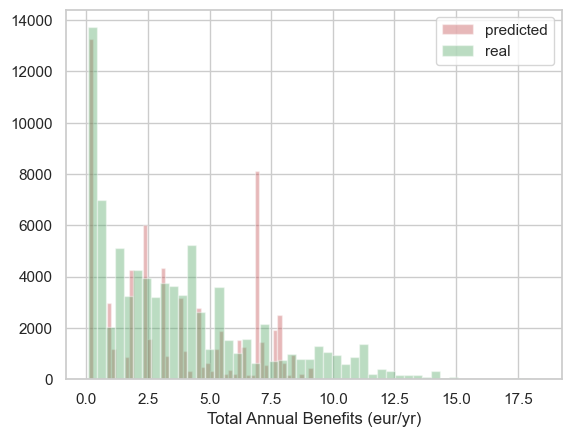

In [58]:
def get_reg_Linear(trees_df):
    x_train, x_validation, y_train, y_validation = train_test_split(
        trees_df[['Name_id', 'DBH (cm)', 'Height (m)']],
        trees_df['Total Annual Benefits (eur/yr)'],
        test_size=0.2,
    )

    reg = LinearRegression()
    reg.fit(
        x_train,
        y_train,
    )
    mean_abs_err = mean_absolute_error(y_train, reg.predict(x_train))
    print(mean_abs_err)
    
    print(r2_score(y_validation, reg.predict(x_validation)))

    return reg, x_train

reg_o3, x_train = get_reg_Linear(trees)

a1, a2, a3, b = reg_o3.coef_[0], reg_o3.coef_[1], reg_o3.coef_[2], reg_o3.intercept_

fn = a1 * trees['Name_id'] + a2 * trees['DBH (cm)'] + a3 * trees['Height (m)'] + b

sns.distplot(reg_o3.predict(x_train), kde=False, bins=50, color='r', label='predicted')
sns.distplot(trees['Total Annual Benefits (eur/yr)'], kde=False, bins=50, color='g', label='real')
plt.legend()


7.200852032207291e-15
0.9982492875923077


/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


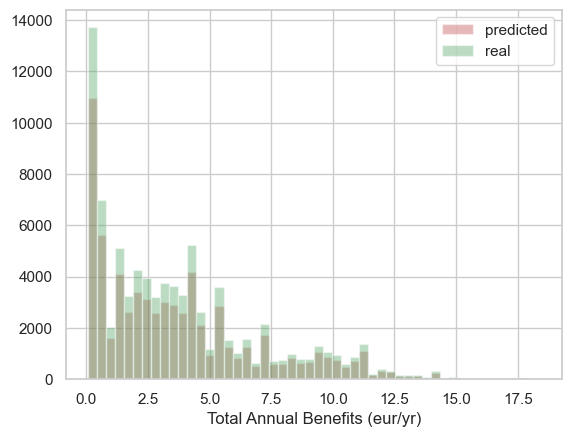

In [59]:
def get_reg_DecisionTree(trees_df):
    x_train, x_validation, y_train, y_validation = train_test_split(
        trees_df[['Name_id', 'DBH (cm)', 'Height (m)']],
        trees_df['Total Annual Benefits (eur/yr)'],
        test_size=0.2,
    )

    reg = DecisionTreeRegressor()
    reg.fit(
        x_train,
        y_train,
    )
    mean_abs_err = mean_absolute_error(y_train, reg.predict(x_train))
    print(mean_abs_err)
    
    print(r2_score(y_validation, reg.predict(x_validation)))

    sns.distplot(reg.predict(x_train), kde=False, bins=50, color='r', label='predicted')
    sns.distplot(trees['Total Annual Benefits (eur/yr)'], kde=False, bins=50, color='g', label='real')
    plt.legend()

    return reg, x_train

reg_o3, x_train = get_reg_DecisionTree(trees)

The decision tree regression model may be a good fit for the trees Dataframe brcause it is able to capture nonlinear relationships, feature interactions, and important variables, while being robust to outliers.

0.004624268958519781
0.9976661568582155


/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


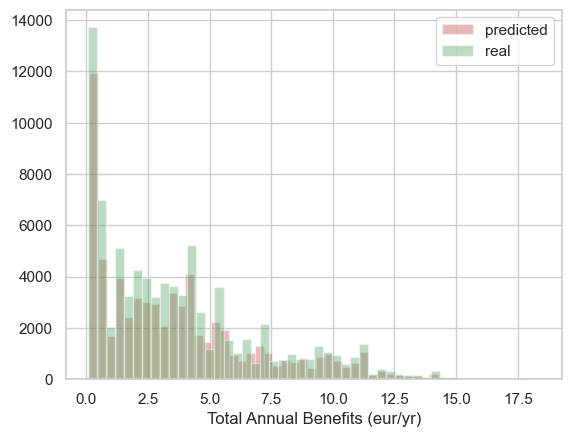

In [60]:
def get_reg_RandomForest(trees_df):
    x_train, x_validation, y_train, y_validation = train_test_split(
        trees_df[['Name_id', 'DBH (cm)', 'Height (m)']],
        trees_df['Total Annual Benefits (eur/yr)'],
        test_size=0.2,
    )

    reg = RandomForestRegressor()
    reg.fit(
        x_train,
        y_train,
    )
    mean_abs_err = mean_absolute_error(y_train, reg.predict(x_train))
    print(mean_abs_err)
    
    print(r2_score(y_validation, reg.predict(x_validation)))

    sns.distplot(reg.predict(x_train), kde=False, bins=50, color='r', label='predicted')
    sns.distplot(trees['Total Annual Benefits (eur/yr)'], kde=False, bins=50, color='g', label='real')
    plt.legend()

    return reg, x_train

reg_o3, x_train = get_reg_RandomForest(trees)

# Considerations

Maybe we can think that Spatial Regression is not good in our case because "trees" are non influenced by their neighbors. For example we can imagine that the fact that a olm is surrounded by trees of other species does not influence its Total Annual Benefit, even if the other trees are of the same species, have the same DBH, etc.

Maybe Linear regression and other regressions are good because there is very little difference between total annual benefit of trees of the same species, same DBH, etc. and the difference is not influenced by the other trees.

# Best tree model

In [61]:
# Load the data 
trees = gpd.read_file('../data/geojson/geo_data_trees.geojson')

# ACTIVATE IF WANT TO WORK WITH A SAMPLE OF THE DATA
# take just the first 1000 rows
#trees = trees.iloc[:1000]
# remove the last row of the data (summary)
trees = trees.drop([len(trees)-1])

trees['Name_id'] = trees['Name'].astype('category').cat.codes

In [62]:
# Define a function to suggest the best tree to plant at a given location
def suggest_tree(trees, latitude, longitude):
    # Find the trees in a distance of 3 meters
    trees['Distance'] = trees.apply(
        lambda row: geopy.distance.distance((latitude, longitude), (row['Latitude'], row['Longitude'])).meters,
        axis=1
    )
    #trees = trees[trees['Distance'] <= 3]
    # Select the trees with the highest benefits
    trees = trees.sort_values(by=['Total Annual Benefits (eur/yr)'], ascending=False)
    
    if (len(trees[trees['Distance'] <= 3]) > 0):
        
        # if there is a Oak as first suggestion, take the first tree that is not an Oak
        if(trees[trees['Distance'] <= 3].iloc[0]['Name'] == 'Oak'):
            trees = trees[trees['Name'] != 'Olm']

        # Return the name of the tree with the highest benefits
        return trees.iloc[0]['Name']
    else:
        return trees.iloc[0]['Name']

# Test the function
latitude = 44.4949
longitude = 11.3426
suggested_tree = suggest_tree(trees, latitude, longitude)
print('Suggested tree:', suggested_tree)

Suggested tree: Sycamore maple


# Madrid file suggestions:
It advises against planting trees too close to buildings or in areas with insufficient sidewalk width for pedestrians to pass by safely.
It also recommends avoiding species with characteristics that could be problematic, such as excessive leaf drop or thorns

In [63]:
# now we want to find the places, that have the highest need for trees

# Load the data of the circoscrizioni
circoscrizioni = gpd.read_file('../data/geojson/circoscrizioni.geojson')

# find the trees within each circoscrizione
trees_within_circoscrizioni = []
for circoscrizione in circoscrizioni['nome']:
    area = circoscrizioni[circoscrizioni['nome'] == circoscrizione]
    trees_within_circoscrizioni.append(
        trees[trees.geometry.within(area.iloc[0].geometry)]
    )

# calculate the total benefits for each circoscrizione
total_benefits = []
for trees_within_circoscrizione in trees_within_circoscrizioni:
    total_benefits.append(
        trees_within_circoscrizione['Total Annual Benefits (eur/yr)'].astype(float).sum()
    )

print('total_benefits:', total_benefits)

# calculate the proportion of the total benefits for each circoscrizione, based on the area
total_benefits_proportion = []
for i in range(len(total_benefits)):
    total_benefits_proportion.append(
        {
            'name': circoscrizioni.iloc[i]['nome'],
            'total_benefits': total_benefits[i],
            # the proportion is the total benefits divided by the area of the circoscrizione
            'proportion': float(total_benefits[i]) / float(circoscrizioni.iloc[i]['area'])
        }   
    )
print('total_benefits_proportion:', total_benefits_proportion)

total_benefits: [6330.040000000001, 7203.71, 8145.93, 7026.6900000000005, 8144.810000000001, 475.41, 1160.24, 5304.4400000000005, 5987.72, 8707.73, 116.58999999999999, 6916.08, 4307.46, 615.7500000000001, 5087.99, 2802.31, 6846.389999999999, 190.58999999999997, 3131.9700000000003, 6328.83, 153.58999999999995, 4362.120000000001, 1624.27, 5037.11, 1497.19, 405.30999999999995, 1651.52, 4830.07, 17521.41, 5599.27, 9240.17, 288.19, 1320.47, 1346.06, 104.71999999999998, 3288.44, 5120.03, 4019.67, 304.07, 646.5999999999999, 7025.710000000001, 4898.96, 1631.81, 5001.92, 434.83, 9767.170000000002, 352.85, 3178.55, 9478.900000000001, 798.0600000000001, 11663.77, 6270.32, 2012.3000000000002, 4349.42, 0.0, 2101.99, 2283.38, 2189.83, 1971.03, 295.2499999999999, 2302.8599999999997, 0.0, 206.42, 800.0000000000001, 1248.1799999999998, 3820.0899999999997, 535.9, 1271.42, 4860.7300000000005, 2161.7400000000002, 1726.75, 3270.86, 2269.38, 406.1, 4341.0, 4629.44, 43.290000000000006, 3385.4200000000005, 12

In [64]:
# GET STREETS FROM OPENSTREETMAP

import overpy

# Define the bounding box (replace with coordinates for your city)
bbox = ( 44.455494, 11.280470,44.553484 , 11.422880)  # (min lat, min lon, max lat, max lon)

# Initialize the Overpass API
api = overpy.Overpass()

# Query for streets within the bounding box
query = f"""
way["highway"~"motorway|primary|secondary|tertiary|residential"]
({bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]});
(._;>;);
out body;
"""

result = api.query(query)

print('results', len(result.ways))

results 6299


In [65]:
# Load the data of the parks in Bologna, from OpenStreetMap
parks = gpd.read_file('../data/geojson/parks_in_bologna.geojson')

# Let's find the trees that are placed in a park in Bologna
trees_in_parks = gpd.sjoin(trees, parks, predicate='within')

#plot the trees in parks
#trees_in_parks.explore()
total_benefits_parks = []

# Create a GeoDataFrame for parks once
parks_gdf = gpd.GeoDataFrame(parks[['id', 'geometry']], crs=trees.crs)

for park_id, park_geometry in parks_gdf[['id', 'geometry']].values:
    # Find the trees within the park
    trees_in_park = trees[trees.geometry.within(park_geometry)]
    # Calculate the total benefits of the trees within the park
    total_benefits_park = trees_in_park['Total Annual Benefits (eur/yr)'].astype(float).sum()
    # Calculate the proportion of the total benefits
    park_area = park_geometry.area
    total_benefits_proportion_parks = total_benefits_park / park_area
    # Append the name of the park and the total benefits proportion to the list
    total_benefits_parks.append({
        'id': park_id,
        'name': parks[parks['id'] == park_id]['name'].values[0],
        'proportion': total_benefits_proportion_parks
    })

# drop the ones with proportion 0
total_benefits_parks = [park for park in total_benefits_parks if park['proportion'] > 0]

# Find the park with the lowest proportion
park_with_lowest_proportion = min(total_benefits_parks, key=lambda x: x['proportion'])
park_with_lowest_proportion

/var/folders/j8/fjrnp8w15sbf5q2fdgnpb0br0000gn/T/ipykernel_10784/119976543.py:21: RuntimeWarning: invalid value encountered in double_scalars
  total_benefits_proportion_parks = total_benefits_park / park_area


{'id': 'way/235823928',
 'name': 'Parco Villa Aldini',
 'proportion': 737016.9379012489}

In [66]:
# Load the data of the schools in Bologna, from OpenStreetMap
schools = gpd.read_file('../data/geojson/schools_in_bologna.geojson')

# Create a GeoDataFrame for parks once
schools_gdf = gpd.GeoDataFrame(schools[['id', 'geometry']], crs=trees.crs)

In [67]:
# Load the data of the parking lots in Bologna, from OpenStreetMap
parking_lots = gpd.read_file('../data/geojson/parking_lots_in_bologna.geojson')

# Create a GeoDataFrame for parks once
parking_lots_gdf = gpd.GeoDataFrame(parking_lots[['id', 'geometry']], crs=trees.crs)

In [68]:
# Read the json file NDVI_circoscrizioni.json

with open('../data/NDVI_circoscrizioni.json') as f:
    NDVI_circoscrizioni = json.load(f)

# print the max NDVI, it is saved like this: 'TRIUMVIRATO-PIETRA': 4405.094891509561,
max_ndvi = max(NDVI_circoscrizioni.items(), key=lambda x: x[1])
min_ndvi = min(NDVI_circoscrizioni.items(), key=lambda x: x[1])
print(max_ndvi)
print(min_ndvi)

('VIA DEL GENIO', 6357.26751656043)
('MARCONI-1', 1764.7354242058705)


In [69]:
from shapely.geometry import LineString

def suggest_tree_circoscrizione(circoscrizione_gdf, trees):
    # Find the circoscrizione in the circoscrizioni GeoDataFrame
    circoscrizioni_current = circoscrizioni[circoscrizioni['nome'] == circoscrizione_gdf['name']]
    if(circoscrizioni_current.iloc[0]['nome'] == 'MARCONI-1'):
        print('MARCONI-1')

    trees_within_circoscrizione = gpd.sjoin(trees, circoscrizioni_current, predicate='within')


    if len(trees_within_circoscrizione) == 0:
        if(circoscrizioni_current.iloc[0]['nome'] == 'MARCONI-1'):
            print('trees_within_circoscrizione', len(trees_within_circoscrizione))
        schools_within_circoscrizione = gpd.sjoin(schools, circoscrizioni_current, predicate='within')
        if len(schools_within_circoscrizione) > 0:
            # Select a random school and place the tree near it
            random_school = schools_within_circoscrizione.sample()
            suggested_position = {
                'x': random_school.iloc[0].geometry.centroid.x - 0.00005,
                'y': random_school.iloc[0].geometry.centroid.y
            }
            return trees.sort_values(by=['Total Annual Benefits (eur/yr)'], ascending=False).iloc[0]['Name'], suggested_position
        else:
            parking_lots_within_circoscrizione = gpd.sjoin(parking_lots, circoscrizioni_current, predicate='within')
            if len(parking_lots_within_circoscrizione) > 0:
                # Select a random parking lot and place the tree near it (random_parking_lot.iloc[0].geometry is a Polygon)
                random_parking_lot = parking_lots_within_circoscrizione.sample()
                suggested_position = {
                    'x': random_parking_lot.iloc[0].geometry.centroid.x - 0.00005,
                    'y': random_parking_lot.iloc[0].geometry.centroid.y
                }
                return trees.sort_values(by=['Total Annual Benefits (eur/yr)'], ascending=False).iloc[0]['Name'], suggested_position
            else:
                suggested_position = {
                    'x': circoscrizioni_current.total_bounds[0] + (circoscrizioni_current.total_bounds[2] - circoscrizioni_current.total_bounds[0]) * np.random.random(),
                    'y': circoscrizioni_current.total_bounds[1] + (circoscrizioni_current.total_bounds[3] - circoscrizioni_current.total_bounds[1]) * np.random.random()
                }
                return trees.sort_values(by=['Total Annual Benefits (eur/yr)'], ascending=False).iloc[0]['Name'], suggested_position
        
    else: 
        if(circoscrizioni_current.iloc[0]['nome'] == 'MARCONI-1'):
            print('More', len(trees_within_circoscrizione))
        # check if there are some parks in the circoscrizione
        parks_within_circoscrizione = gpd.sjoin(parks_gdf, circoscrizioni_current, predicate='within')
        # if there are some parks in the circoscrizione and their total benefits proportion is lower that the average, we wanto to plant a tree in the park with the lowest proportion
        if len(parks_within_circoscrizione) > 0:
            print ('parks_within_circoscrizione', parks_within_circoscrizione['id'])
            # Calculate the average of the total benefits proportion
            total_benefits_proportion_average = sum([park['proportion'] for park in total_benefits_parks]) / len(total_benefits_parks)
            # Find the parks with a total benefits proportion lower than the average
            parks_with_low_proportion = [park for park in total_benefits_parks if park['proportion'] < total_benefits_proportion_average and park['id'] in parks_within_circoscrizione['id'].tolist()]
            #parks_with_low_proportion = [park for park in total_benefits_parks if park['proportion'] < total_benefits_proportion_average]
            # Find the park with the lowest proportion
            print ('parks_with_low_proportion', len(parks_with_low_proportion))
            if(len(parks_with_low_proportion) != 0) :

                park_with_lowest_proportion = min(parks_with_low_proportion, key=lambda x: x['proportion'])
                
                # Find the geometry of the park with the lowest proportion
                park_with_lowest_proportion_geometry = parks_gdf[parks_gdf['id'] == parks[parks['name'] == park_with_lowest_proportion['name']]['id'].values[0]].iloc[0].geometry
                # Find the trees within the park with the lowest proportion
                trees_within_park_with_lowest_proportion = trees[trees.geometry.within(park_with_lowest_proportion_geometry)]
                #trees_within_park_with_lowest_proportion = trees_within_circoscrizione[trees_within_circoscrizione.geometry.within(park_with_lowest_proportion_geometry)]
                # Find the tree with the highest benefits within the park with the lowest proportion
                suggested_tree = trees_within_park_with_lowest_proportion.sort_values(by=['Total Annual Benefits (eur/yr)'], ascending=False).iloc[0]['Name']
                # Suggest a position near the tree with the highest benefits within the park with the lowest proportion
                suggested_position = {
                    'x': trees_within_park_with_lowest_proportion.sort_values(by=['Total Annual Benefits (eur/yr)'],
                                                                                ascending=False).iloc[0].geometry.x - 0.00005,
                    'y': trees_within_park_with_lowest_proportion.sort_values(by=['Total Annual Benefits (eur/yr)'],
                                                                                ascending=False).iloc[0].geometry.y
                }
                return suggested_tree, suggested_position
        schools_within_circoscrizione = gpd.sjoin(schools, circoscrizioni_current, predicate='within')
        if len(schools_within_circoscrizione) > 0:
            if(circoscrizioni_current.iloc[0]['nome'] == 'MARCONI-1'):
                print('More_2', len(schools_within_circoscrizione))
            # Select a random school and place the tree near it
            random_school = schools_within_circoscrizione.sample()
            suggested_position = {
                'x': random_school.iloc[0].geometry.centroid.x - 0.00005,
                'y': random_school.iloc[0].geometry.centroid.y
            }
            return trees.sort_values(by=['Total Annual Benefits (eur/yr)'], ascending=False).iloc[0]['Name'], suggested_position
        else:
            parking_lots_within_circoscrizione = gpd.sjoin(parking_lots, circoscrizioni_current, predicate='within')
            if len(parking_lots_within_circoscrizione) > 0:
                if(circoscrizioni_current.iloc[0]['nome'] == 'MARCONI-1'):
                    print('More_3', len(parking_lots_within_circoscrizione))
                # Select a random parking lot and place the tree near it (random_parking_lot.iloc[0].geometry is a Polygon)
                random_parking_lot = parking_lots_within_circoscrizione.sample()
                suggested_position = {
                    'x': random_parking_lot.iloc[0].geometry.centroid.x - 0.00005,
                    'y': random_parking_lot.iloc[0].geometry.centroid.y
                }
                return trees.sort_values(by=['Total Annual Benefits (eur/yr)'], ascending=False).iloc[0]['Name'], suggested_position
            else:
                # Find the tree with the highest benefits
                suggested_tree = trees_within_circoscrizione.sort_values(by=['Total Annual Benefits (eur/yr)'], ascending=False).iloc[0]['Name']

                # take a random tree in the circoscrizione
                random_tree = trees_within_circoscrizione.sample()

                # Suggest a position near the random tree, the geometry is a Point, put the new tree 5 m ovest of the random tree
                suggested_position = {
                    'x': random_tree.iloc[0].geometry.x - 0.00005,
                    'y': random_tree.iloc[0].geometry.y
                }
                
                return suggested_tree, suggested_position

    if 0 == 0:
        # Find a suitable location along the streets
        bbox = circoscrizioni_current.total_bounds
        query = f"""
        way["highway"~"motorway|primary|secondary|tertiary|residential"]
        ({bbox[1]},{bbox[0]},{bbox[3]},{bbox[2]});
        (._;>;);
        out body;
        """
        result = api.query(query)

        # Convert the ways to LineString geometries
        street_geometries = [LineString([(float(node.lon), float(node.lat)) for node in way.nodes]) for way in result.ways]

        print('street_geometries', street_geometries)

        # Find streets within the circoscrizione
        #trees_within_circoscrizione = gpd.sjoin(trees, circoscrizioni_current, predicate='within')
        # Change the CRS of the street geometries to the same as the circoscrizione
        street_geometries = gpd.GeoDataFrame(geometry=street_geometries)
        street_geometries.crs = 'EPSG:4326'
        street_geometries = street_geometries.to_crs(circoscrizioni_current.crs)
        streets_within_circoscrizione = gpd.sjoin(street_geometries, circoscrizioni_current, predicate='within')

        # Rename or drop 'index_left' and 'index_right' columns if they exist
        if 'index_left' in trees_within_circoscrizione.columns:
            trees_within_circoscrizione = trees_within_circoscrizione.rename(columns={'index_left': 'index_left_old'})
        if 'index_right' in trees_within_circoscrizione.columns:
            trees_within_circoscrizione = trees_within_circoscrizione.rename(columns={'index_right': 'index_right_old'})

        # Find streets with existing trees
        streets_with_trees = []
        for street in streets_within_circoscrizione.geometry:
            # change the crs of the street to the same as the trees
            street = gpd.GeoDataFrame(geometry=[street])
            street.crs = circoscrizioni_current.crs
            # Find the trees near the street
            
            trees_within_street = gpd.sjoin(trees_within_circoscrizione, street, predicate='within')
            if len(trees_within_street) > 0:
                streets_with_trees.append(street)

        if len(streets_with_trees) > 0:
            # Suggest a position near an existing tree along a street
            suggested_position = streets_with_trees.iloc[0].interpolate(0.1, normalized=True)

            return suggested_tree, suggested_position
        else:
            # If there are no streets with trees, return only the suggested tree
            return suggested_tree, None


In [82]:
# give some random cost to each unique species
unique_species = trees['Name'].unique()
costs = {}
for species in unique_species:
    costs[species] = np.random.randint(1, 100)

In [71]:
import geopandas as gpd
#import pysal
import libpysal as lp
from spreg import OLS
import numpy as np
from pysal.model import spreg
from pysal.lib import weights
from scipy import stats
import pandas as pd
import geopandas as gpd
import seaborn as sns
import osmnx as ox
sns.set(style="whitegrid")

# WE ARE WORKING WITH A SAMPLE OF THE DATA
# Load your tree dataset with coordinates and ecological benefits
data = gpd.read_file('../data/geojson/geo_data_trees.geojson')
# take a random sample of the dataset (5000 rows)
#trees = trees.sample(n=5000)

data = data.drop([len(data)-1])

# Read OSM data - get administrative boundaries

# define the place query
query = {'city': 'Bologna'}

# get the boundaries of the place (add additional buffer around the query)
boundaries = ox.geocode_to_gdf(query, buffer_dist=5000)

# Filter data geographically
trees_filtered = gpd.sjoin(data, boundaries[["geometry"]])
trees_filtered = trees_filtered.reset_index(drop=True)
trees_filtered['Total Annual Benefits (eur/yr)'] = trees_filtered['Total Annual Benefits (eur/yr)'].str.replace(',', '.').astype(float)
trees_filtered["Total Annual Benefits (eur/yr)"] = trees_filtered["Total Annual Benefits (eur/yr)"].astype(float)
#trees_filtered['Carbon Storage (kg)'] = trees_filtered['Carbon Storage (kg)'].astype(float)
trees_filtered['DBH (cm)'] = trees_filtered['DBH (cm)'].astype(float)
trees_filtered["Height (m)"] = trees_filtered["Height (m)"].astype(float)
trees_filtered['Name_id'] = trees_filtered['Name'].astype('category').cat.codes
explanatory_vars = ['DBH (cm)', 'Name_id', 'Latitude', 'Longitude', 'Height (m)']
trees_filtered["log_benefit"] = np.log(trees_filtered["Total Annual Benefits (eur/yr)"] + 0.000001)
w = weights.KNN.from_dataframe(trees_filtered, k=8)
w.transform = 'R'

# Create weigts
w_benefit = weights.KNN.from_dataframe(trees_filtered, k=8)

# Assign spatial lag based on the pool values
lagged = trees_filtered.assign(w_benefit=weights.spatial_lag.lag_spatial(w_benefit, trees_filtered['Total Annual Benefits (eur/yr)'].values))
# Add pool to the explanatory variables
extended_vars = explanatory_vars + ["w_benefit"]

m2 = spreg.OLS(lagged[['Total Annual Benefits (eur/yr)']].values, lagged[extended_vars].values, 
               name_y = 'Total Annual Benefits (eur/yr)', name_x = extended_vars)

/var/folders/j8/fjrnp8w15sbf5q2fdgnpb0br0000gn/T/ipykernel_10784/468719916.py:29: UserWarning: The buffer_dist argument as been deprecated and will be removed in a future release. Buffer your results directly, if desired.
  boundaries = ox.geocode_to_gdf(query, buffer_dist=5000)
/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 277 disconnected components.
  warnings.warn(message)


In [74]:
import geopandas as gpd
import numpy as np
import libpysal as lp
from spreg import OLS

def total_annual_benefits_prediction (new_data):
    # Convert to DataFrame
    new_data_df = pd.DataFrame(new_data)

    # Merge new data with the existing dataset for spatial weights calculation
    combined_data = trees_filtered.append(new_data_df, ignore_index=True)

    # Recalculate weights with the new point
    coords = combined_data[['Longitude', 'Latitude']]
    w_combined = lp.weights.KNN.from_array(coords.values, k=8)
    w_combined.transform = 'R'
    combined_data['w_benefit'] = lp.weights.spatial_lag.lag_spatial(w_combined, combined_data['Total Annual Benefits (eur/yr)'])

    # Extract the spatial lag value for the new data point
    new_point_lag = combined_data['w_benefit'].iloc[-1]

    # Prepare the input data for prediction, including the spatial lag
    new_data_input = new_data_df.assign(w_benefit=new_point_lag)
    X_new = new_data_input[extended_vars].values

    # Add intercept term to input data for prediction
    X_new_with_intercept = np.hstack((np.ones((X_new.shape[0], 1)), X_new))

    # Use the coefficients from the model to predict
    coefficients = m2.betas
    predicted_benefit = np.dot(X_new_with_intercept, coefficients)

    # Print the predicted 'Total Annual Benefits (eur/yr)'
    print("Predicted Total Annual Benefits (eur/yr):", predicted_benefit[0])
    return predicted_benefit[0]

In [84]:
budget = 1000

used_budget = 0
# let's choose where to place the 100 trees, based on the proportion of the total benefits, we want to place the tree where the proportion is the lowest
trees_to_place = []
total_new_benefit = 0
while (used_budget < budget):
    # take the 30 circoscrizioni with the lowest NDVI index
    circoscrizioni_with_lowest_ndvi = sorted(NDVI_circoscrizioni.items(), key=lambda x: x[1])[:30]
    #print('circoscrizioni_with_lowest_ndvi', circoscrizioni_with_lowest_ndvi)
    circoscrizioni_with_lowest_ndvi_names = [circoscrizione[0] for circoscrizione in circoscrizioni_with_lowest_ndvi]

    # find the circoscrizione with the lowest proportion from the circoscrizioni_with_lowest_ndvi
    filtered_total_benefits_proportion = [item for item in total_benefits_proportion if item['name'] in circoscrizioni_with_lowest_ndvi_names]
    circoscrizione_with_lowest_proportion = min(filtered_total_benefits_proportion, key=lambda x:x['proportion'])
    #print(circoscrizione_with_lowest_proportion['name'])

    # find the best tree to place in that circoscrizione, find the tree that creates the highest benefits in that circoscrizione
    suggested_tree, suggested_position = suggest_tree_circoscrizione(circoscrizione_with_lowest_proportion, trees)

    print('suggested_tree', suggested_tree)
    print('suggested_position', suggested_position)

    if(costs[suggested_tree] > budget - used_budget):
        break

    # calculate the new proportion of the circoscrizione, update the total_benefits_proportion, add the mean value of benefit for the suggested tree to the total benefits
    old_benefit = total_benefits_proportion[total_benefits_proportion.index(circoscrizione_with_lowest_proportion)]['total_benefits'].astype(float)
    # we want to predict the benefits of the tree, based on the avarage DBH and Height of the tree from the regression model we trained
    # New tree data
    new_data = {'DBH (cm)': [trees[trees['Name'] == suggested_tree]['DBH (cm)'].astype(float).mean()], 
                # find the name_id of the tree that is called as the suggested_tree (return just one value)
                'Name_id': [trees[trees['Name'] == suggested_tree]['Name_id'].astype('category').cat.codes.mean()],
                'Latitude': [suggested_position['y']],
                'Longitude': [suggested_position['x']],
                'Height (m)': [trees[trees['Name'] == suggested_tree]['Height (m)'].astype(float).mean()]}
    # Predict the total annual benefits
    predicted_benefit = total_annual_benefits_prediction(new_data)
    # convert the predicted_benefit to float
    new_tree_benefit = float(predicted_benefit)
    total_new_benefit = total_new_benefit + new_tree_benefit
    new_benefit = old_benefit + reg_o3.predict([[trees[trees['Name'] == suggested_tree]['Name_id'].astype('category').cat.codes.mean(), trees[trees['Name'] == suggested_tree]['DBH (cm)'].astype(float).mean(), trees[trees['Name'] == suggested_tree]['Height (m)'].astype(float).mean()]])
    #new_benefit = old_benefit + trees[trees['Name'] == suggested_tree]['Total Annual Benefits (eur/yr)'].astype(float).mean()

    # add the tree to the list of the trees to place, we want to add the name of the tree and the circoscrizione
    trees_to_place.append({
        'tree': suggested_tree,
        'circoscrizione': circoscrizione_with_lowest_proportion['name'],
        'latitude': suggested_position['y'],
        'longitude': suggested_position['x'],
        'benefit': new_tree_benefit
    })

    # update the total_benefits_proportion
    total_benefits_proportion[total_benefits_proportion.index(circoscrizione_with_lowest_proportion)]['total_benefits'] = new_benefit
    #'proportion': float(total_benefits[i]) / float(circoscrizioni.iloc[i]['area']) new_benefit / circoscrizioni[circoscrizioni['nome'] == circoscrizione_with_lowest_proportion['name']].iloc[0]['area'].astype(float)
    total_benefits_proportion[total_benefits_proportion.index(circoscrizione_with_lowest_proportion)]['proportion'] = new_benefit / float(circoscrizioni[circoscrizioni['nome'] == circoscrizione_with_lowest_proportion['name']].iloc[0]['area'])

    # update the used budget
    used_budget = used_budget + costs[suggested_tree]
    print ('used_budget', used_budget)

print('total_new_benefit', total_new_benefit)


suggested_tree Sycamore maple
suggested_position {'x': 11.33910160166018, 'y': 44.49401052644469}
new_data {'DBH (cm)': [35.8045223880597], 'Name_id': [0.0], 'Latitude': [44.49401052644469], 'Longitude': [11.33910160166018], 'Height (m)': [8.273134328358209]}


/var/folders/j8/fjrnp8w15sbf5q2fdgnpb0br0000gn/T/ipykernel_10784/3720113574.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_data = trees_filtered.append(new_data_df, ignore_index=True)
/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 277 disconnected components.
  warnings.warn(message)


Predicted Total Annual Benefits (eur/yr): [2.41344557]
used_budget 32
MARCONI-1


/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


More 10
parks_within_circoscrizione 393    way/1187628486
Name: id, dtype: object
parks_with_low_proportion 0
More_2 1
suggested_tree Sycamore maple
suggested_position {'x': 11.338694048168044, 'y': 44.496914384494914}
new_data {'DBH (cm)': [35.8045223880597], 'Name_id': [0.0], 'Latitude': [44.496914384494914], 'Longitude': [11.338694048168044], 'Height (m)': [8.273134328358209]}


/var/folders/j8/fjrnp8w15sbf5q2fdgnpb0br0000gn/T/ipykernel_10784/3720113574.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_data = trees_filtered.append(new_data_df, ignore_index=True)
/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 277 disconnected components.
  warnings.warn(message)


Predicted Total Annual Benefits (eur/yr): [2.54189364]
used_budget 64


/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


suggested_tree Sycamore maple
suggested_position {'x': 11.365305750000001, 'y': 44.49020335}
new_data {'DBH (cm)': [35.8045223880597], 'Name_id': [0.0], 'Latitude': [44.49020335], 'Longitude': [11.365305750000001], 'Height (m)': [8.273134328358209]}


/var/folders/j8/fjrnp8w15sbf5q2fdgnpb0br0000gn/T/ipykernel_10784/3720113574.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_data = trees_filtered.append(new_data_df, ignore_index=True)
/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 277 disconnected components.
  warnings.warn(message)


Predicted Total Annual Benefits (eur/yr): [2.43092791]
used_budget 96


/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


suggested_tree Sycamore spp
suggested_position {'x': 11.3448859172092, 'y': 44.4940125230839}
new_data {'DBH (cm)': [39.36666217948718], 'Name_id': [0.0], 'Latitude': [44.4940125230839], 'Longitude': [11.3448859172092], 'Height (m)': [13.75849358974359]}


/var/folders/j8/fjrnp8w15sbf5q2fdgnpb0br0000gn/T/ipykernel_10784/3720113574.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_data = trees_filtered.append(new_data_df, ignore_index=True)
/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 277 disconnected components.
  warnings.warn(message)


Predicted Total Annual Benefits (eur/yr): [3.33206615]
used_budget 160


/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


suggested_tree Sycamore maple
suggested_position {'x': 11.34031308151786, 'y': 44.49422114500346}
new_data {'DBH (cm)': [35.8045223880597], 'Name_id': [0.0], 'Latitude': [44.49422114500346], 'Longitude': [11.34031308151786], 'Height (m)': [8.273134328358209]}


/var/folders/j8/fjrnp8w15sbf5q2fdgnpb0br0000gn/T/ipykernel_10784/3720113574.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_data = trees_filtered.append(new_data_df, ignore_index=True)
/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 277 disconnected components.
  warnings.warn(message)


Predicted Total Annual Benefits (eur/yr): [2.68677198]
used_budget 192
MARCONI-1


/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


More 10
parks_within_circoscrizione 393    way/1187628486
Name: id, dtype: object
parks_with_low_proportion 0
More_2 1
suggested_tree Sycamore maple
suggested_position {'x': 11.338694048168044, 'y': 44.496914384494914}
new_data {'DBH (cm)': [35.8045223880597], 'Name_id': [0.0], 'Latitude': [44.496914384494914], 'Longitude': [11.338694048168044], 'Height (m)': [8.273134328358209]}


/var/folders/j8/fjrnp8w15sbf5q2fdgnpb0br0000gn/T/ipykernel_10784/3720113574.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_data = trees_filtered.append(new_data_df, ignore_index=True)
/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 277 disconnected components.
  warnings.warn(message)


Predicted Total Annual Benefits (eur/yr): [2.54189364]
used_budget 224


/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


suggested_tree Sycamore maple
suggested_position {'x': 11.359575642952986, 'y': 44.49136507305282}
new_data {'DBH (cm)': [35.8045223880597], 'Name_id': [0.0], 'Latitude': [44.49136507305282], 'Longitude': [11.359575642952986], 'Height (m)': [8.273134328358209]}


/var/folders/j8/fjrnp8w15sbf5q2fdgnpb0br0000gn/T/ipykernel_10784/3720113574.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_data = trees_filtered.append(new_data_df, ignore_index=True)
/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 277 disconnected components.
  warnings.warn(message)


Predicted Total Annual Benefits (eur/yr): [2.50400507]
used_budget 256


/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


suggested_tree Sycamore maple
suggested_position {'x': 11.34031308151786, 'y': 44.49422114500346}
new_data {'DBH (cm)': [35.8045223880597], 'Name_id': [0.0], 'Latitude': [44.49422114500346], 'Longitude': [11.34031308151786], 'Height (m)': [8.273134328358209]}


/var/folders/j8/fjrnp8w15sbf5q2fdgnpb0br0000gn/T/ipykernel_10784/3720113574.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_data = trees_filtered.append(new_data_df, ignore_index=True)
/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 277 disconnected components.
  warnings.warn(message)


Predicted Total Annual Benefits (eur/yr): [2.68677198]
used_budget 288


/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


suggested_tree Sycamore spp
suggested_position {'x': 11.3451630995412, 'y': 44.4919106184123}
new_data {'DBH (cm)': [39.36666217948718], 'Name_id': [0.0], 'Latitude': [44.4919106184123], 'Longitude': [11.3451630995412], 'Height (m)': [13.75849358974359]}


/var/folders/j8/fjrnp8w15sbf5q2fdgnpb0br0000gn/T/ipykernel_10784/3720113574.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_data = trees_filtered.append(new_data_df, ignore_index=True)
/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 277 disconnected components.
  warnings.warn(message)


Predicted Total Annual Benefits (eur/yr): [3.45008258]
used_budget 352
MARCONI-1


/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


More 10
parks_within_circoscrizione 393    way/1187628486
Name: id, dtype: object
parks_with_low_proportion 0
More_2 1
suggested_tree Sycamore maple
suggested_position {'x': 11.338694048168044, 'y': 44.496914384494914}
new_data {'DBH (cm)': [35.8045223880597], 'Name_id': [0.0], 'Latitude': [44.496914384494914], 'Longitude': [11.338694048168044], 'Height (m)': [8.273134328358209]}


/var/folders/j8/fjrnp8w15sbf5q2fdgnpb0br0000gn/T/ipykernel_10784/3720113574.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_data = trees_filtered.append(new_data_df, ignore_index=True)
/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 277 disconnected components.
  warnings.warn(message)


Predicted Total Annual Benefits (eur/yr): [2.54189364]
used_budget 384


/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


suggested_tree Sycamore maple
suggested_position {'x': 11.365305750000001, 'y': 44.49020335}
new_data {'DBH (cm)': [35.8045223880597], 'Name_id': [0.0], 'Latitude': [44.49020335], 'Longitude': [11.365305750000001], 'Height (m)': [8.273134328358209]}


/var/folders/j8/fjrnp8w15sbf5q2fdgnpb0br0000gn/T/ipykernel_10784/3720113574.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_data = trees_filtered.append(new_data_df, ignore_index=True)
/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 277 disconnected components.
  warnings.warn(message)


Predicted Total Annual Benefits (eur/yr): [2.43092791]
used_budget 416


/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


suggested_tree Sycamore maple
suggested_position {'x': 11.34072153042267, 'y': 44.493513432527855}
new_data {'DBH (cm)': [35.8045223880597], 'Name_id': [0.0], 'Latitude': [44.493513432527855], 'Longitude': [11.34072153042267], 'Height (m)': [8.273134328358209]}


/var/folders/j8/fjrnp8w15sbf5q2fdgnpb0br0000gn/T/ipykernel_10784/3720113574.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_data = trees_filtered.append(new_data_df, ignore_index=True)
/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 277 disconnected components.
  warnings.warn(message)


Predicted Total Annual Benefits (eur/yr): [2.41171473]
used_budget 448


/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


suggested_tree Sycamore spp
suggested_position {'x': 11.3485355950126, 'y': 44.4919341406908}
new_data {'DBH (cm)': [39.36666217948718], 'Name_id': [0.0], 'Latitude': [44.4919341406908], 'Longitude': [11.3485355950126], 'Height (m)': [13.75849358974359]}


/var/folders/j8/fjrnp8w15sbf5q2fdgnpb0br0000gn/T/ipykernel_10784/3720113574.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_data = trees_filtered.append(new_data_df, ignore_index=True)
/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 277 disconnected components.
  warnings.warn(message)


Predicted Total Annual Benefits (eur/yr): [3.41099895]
used_budget 512
MARCONI-1


/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


More 10
parks_within_circoscrizione 393    way/1187628486
Name: id, dtype: object
parks_with_low_proportion 0
More_2 1
suggested_tree Sycamore maple
suggested_position {'x': 11.338694048168044, 'y': 44.496914384494914}
new_data {'DBH (cm)': [35.8045223880597], 'Name_id': [0.0], 'Latitude': [44.496914384494914], 'Longitude': [11.338694048168044], 'Height (m)': [8.273134328358209]}


/var/folders/j8/fjrnp8w15sbf5q2fdgnpb0br0000gn/T/ipykernel_10784/3720113574.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_data = trees_filtered.append(new_data_df, ignore_index=True)
/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 277 disconnected components.
  warnings.warn(message)


Predicted Total Annual Benefits (eur/yr): [2.54189364]
used_budget 544


/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


suggested_tree Sycamore maple
suggested_position {'x': 11.359575642952986, 'y': 44.49136507305282}
new_data {'DBH (cm)': [35.8045223880597], 'Name_id': [0.0], 'Latitude': [44.49136507305282], 'Longitude': [11.359575642952986], 'Height (m)': [8.273134328358209]}


/var/folders/j8/fjrnp8w15sbf5q2fdgnpb0br0000gn/T/ipykernel_10784/3720113574.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_data = trees_filtered.append(new_data_df, ignore_index=True)
/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 277 disconnected components.
  warnings.warn(message)


Predicted Total Annual Benefits (eur/yr): [2.50400507]
used_budget 576


/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


suggested_tree Sycamore maple
suggested_position {'x': 11.34031308151786, 'y': 44.49422114500346}
new_data {'DBH (cm)': [35.8045223880597], 'Name_id': [0.0], 'Latitude': [44.49422114500346], 'Longitude': [11.34031308151786], 'Height (m)': [8.273134328358209]}


/var/folders/j8/fjrnp8w15sbf5q2fdgnpb0br0000gn/T/ipykernel_10784/3720113574.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_data = trees_filtered.append(new_data_df, ignore_index=True)
/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 277 disconnected components.
  warnings.warn(message)


Predicted Total Annual Benefits (eur/yr): [2.68677198]
used_budget 608


/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


suggested_tree Sycamore spp
suggested_position {'x': 11.3454840437852, 'y': 44.4918192116694}
new_data {'DBH (cm)': [39.36666217948718], 'Name_id': [0.0], 'Latitude': [44.4918192116694], 'Longitude': [11.3454840437852], 'Height (m)': [13.75849358974359]}


/var/folders/j8/fjrnp8w15sbf5q2fdgnpb0br0000gn/T/ipykernel_10784/3720113574.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_data = trees_filtered.append(new_data_df, ignore_index=True)
/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 277 disconnected components.
  warnings.warn(message)


Predicted Total Annual Benefits (eur/yr): [3.44975643]
used_budget 672


/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


suggested_tree Sycamore maple
suggested_position {'x': 11.349497036410424, 'y': 44.49352885003733}
new_data {'DBH (cm)': [35.8045223880597], 'Name_id': [0.0], 'Latitude': [44.49352885003733], 'Longitude': [11.349497036410424], 'Height (m)': [8.273134328358209]}


/var/folders/j8/fjrnp8w15sbf5q2fdgnpb0br0000gn/T/ipykernel_10784/3720113574.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_data = trees_filtered.append(new_data_df, ignore_index=True)
/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 276 disconnected components.
  warnings.warn(message)


Predicted Total Annual Benefits (eur/yr): [2.54890099]
used_budget 704
MARCONI-1


/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


More 10
parks_within_circoscrizione 393    way/1187628486
Name: id, dtype: object
parks_with_low_proportion 0
More_2 1
suggested_tree Sycamore maple
suggested_position {'x': 11.338694048168044, 'y': 44.496914384494914}
new_data {'DBH (cm)': [35.8045223880597], 'Name_id': [0.0], 'Latitude': [44.496914384494914], 'Longitude': [11.338694048168044], 'Height (m)': [8.273134328358209]}


/var/folders/j8/fjrnp8w15sbf5q2fdgnpb0br0000gn/T/ipykernel_10784/3720113574.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_data = trees_filtered.append(new_data_df, ignore_index=True)
/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 277 disconnected components.
  warnings.warn(message)


Predicted Total Annual Benefits (eur/yr): [2.54189364]
used_budget 736


/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


suggested_tree Sycamore maple
suggested_position {'x': 11.365570200000006, 'y': 44.49001275}
new_data {'DBH (cm)': [35.8045223880597], 'Name_id': [0.0], 'Latitude': [44.49001275], 'Longitude': [11.365570200000006], 'Height (m)': [8.273134328358209]}


/var/folders/j8/fjrnp8w15sbf5q2fdgnpb0br0000gn/T/ipykernel_10784/3720113574.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_data = trees_filtered.append(new_data_df, ignore_index=True)
/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 277 disconnected components.
  warnings.warn(message)


Predicted Total Annual Benefits (eur/yr): [2.44827333]
used_budget 768


/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


suggested_tree Sycamore maple
suggested_position {'x': 11.34072153042267, 'y': 44.493513432527855}
new_data {'DBH (cm)': [35.8045223880597], 'Name_id': [0.0], 'Latitude': [44.493513432527855], 'Longitude': [11.34072153042267], 'Height (m)': [8.273134328358209]}


/var/folders/j8/fjrnp8w15sbf5q2fdgnpb0br0000gn/T/ipykernel_10784/3720113574.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_data = trees_filtered.append(new_data_df, ignore_index=True)
/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 277 disconnected components.
  warnings.warn(message)


Predicted Total Annual Benefits (eur/yr): [2.41171473]
used_budget 800


/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


suggested_tree Sycamore maple
suggested_position {'x': 11.349323298476532, 'y': 44.49333297977563}
new_data {'DBH (cm)': [35.8045223880597], 'Name_id': [0.0], 'Latitude': [44.49333297977563], 'Longitude': [11.349323298476532], 'Height (m)': [8.273134328358209]}


/var/folders/j8/fjrnp8w15sbf5q2fdgnpb0br0000gn/T/ipykernel_10784/3720113574.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_data = trees_filtered.append(new_data_df, ignore_index=True)
/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 277 disconnected components.
  warnings.warn(message)


Predicted Total Annual Benefits (eur/yr): [2.5005512]
used_budget 832


/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


suggested_tree Sycamore maple
suggested_position {'x': 11.365570200000006, 'y': 44.49001275}
new_data {'DBH (cm)': [35.8045223880597], 'Name_id': [0.0], 'Latitude': [44.49001275], 'Longitude': [11.365570200000006], 'Height (m)': [8.273134328358209]}


/var/folders/j8/fjrnp8w15sbf5q2fdgnpb0br0000gn/T/ipykernel_10784/3720113574.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_data = trees_filtered.append(new_data_df, ignore_index=True)
/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 277 disconnected components.
  warnings.warn(message)


Predicted Total Annual Benefits (eur/yr): [2.44827333]
used_budget 864
MARCONI-1


/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


More 10
parks_within_circoscrizione 393    way/1187628486
Name: id, dtype: object
parks_with_low_proportion 0
More_2 1
suggested_tree Sycamore maple
suggested_position {'x': 11.338694048168044, 'y': 44.496914384494914}
new_data {'DBH (cm)': [35.8045223880597], 'Name_id': [0.0], 'Latitude': [44.496914384494914], 'Longitude': [11.338694048168044], 'Height (m)': [8.273134328358209]}


/var/folders/j8/fjrnp8w15sbf5q2fdgnpb0br0000gn/T/ipykernel_10784/3720113574.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_data = trees_filtered.append(new_data_df, ignore_index=True)
/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 277 disconnected components.
  warnings.warn(message)


Predicted Total Annual Benefits (eur/yr): [2.54189364]
used_budget 896


/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


suggested_tree Sycamore spp
suggested_position {'x': 11.3448859172092, 'y': 44.4940125230839}
new_data {'DBH (cm)': [39.36666217948718], 'Name_id': [0.0], 'Latitude': [44.4940125230839], 'Longitude': [11.3448859172092], 'Height (m)': [13.75849358974359]}


/var/folders/j8/fjrnp8w15sbf5q2fdgnpb0br0000gn/T/ipykernel_10784/3720113574.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_data = trees_filtered.append(new_data_df, ignore_index=True)
/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 277 disconnected components.
  warnings.warn(message)


Predicted Total Annual Benefits (eur/yr): [3.33206615]
used_budget 960


/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


suggested_tree Sycamore maple
suggested_position {'x': 11.349323298476532, 'y': 44.49333297977563}
new_data {'DBH (cm)': [35.8045223880597], 'Name_id': [0.0], 'Latitude': [44.49333297977563], 'Longitude': [11.349323298476532], 'Height (m)': [8.273134328358209]}


/var/folders/j8/fjrnp8w15sbf5q2fdgnpb0br0000gn/T/ipykernel_10784/3720113574.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_data = trees_filtered.append(new_data_df, ignore_index=True)
/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 277 disconnected components.
  warnings.warn(message)


Predicted Total Annual Benefits (eur/yr): [2.5005512]
used_budget 992


/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


suggested_tree Sycamore maple
suggested_position {'x': 11.33910160166018, 'y': 44.49401052644469}
total_new_benefit 69.83993912269086


<AxesSubplot:>

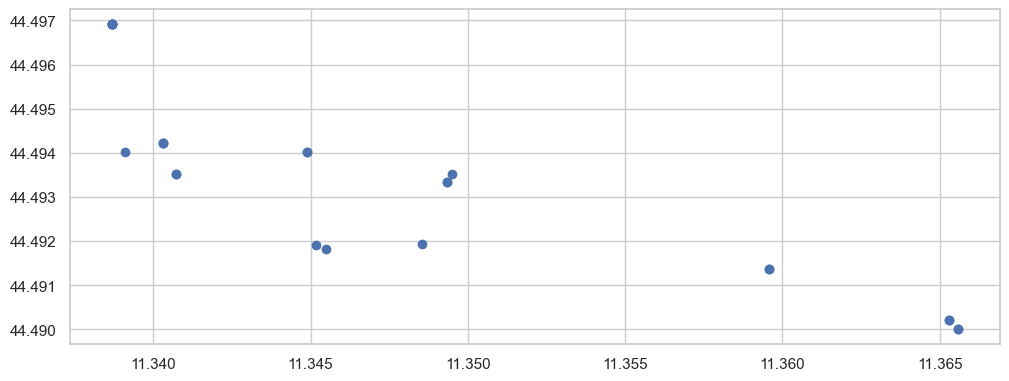

In [85]:
geo_data_trees = gpd.GeoDataFrame(
    trees_to_place,
    crs='EPSG:4326',
    geometry=gpd.points_from_xy(
        [tree['longitude'] for tree in trees_to_place],
        [tree['latitude'] for tree in trees_to_place],
    ),
)

geo_data_trees.to_file("predict_trees.geojson",driver="GeoJSON")

geo_data_trees.plot(figsize=(12,12))

We understood that the area of the geometry is not m^2, is a different unit. Since the used unit is the same for all the objects, we can still use it to compare the areas of the objects.